### Data2BraindecodeFormat
##### Read the info csv table (as created by Read_HCI) and EEG data from BDF files and bring the EEG data into format that is ready to be used by Braindecode toolbox


In [1]:
import pandas as pd
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
import mne
import braindecode

from mne.io import concatenate_raws
from braindecode.datautil.signal_target import SignalAndTarget

In [76]:
# FUNCTIONS

def get_sig(fname, ch):
    
    '''
    Returns signal of the desired channel ch in BDF file fname
    '''
    
    with pyedflib.EdfReader(fname) as f: 
        
        #file_dur=f.getFileDuration()
        #print(header['label'])
        
        header=f.getSignalHeader(ch)
        sig=f.readSignal(ch)
    
    return sig



import subprocess

def find_files(file_name):
    
    '''
    Ubuntu: finds the indicated file and returns a list of all 
    subdirectories that contain file of name file_name
    '''
    
    command = ['locate', file_name]

    output = subprocess.Popen(command, stdout=subprocess.PIPE).communicate()[0]
    output = output.decode()

    search_results = output.split('\n')

    return search_results



# DATASET-SPECIFIC FUNCTIONS

def subjTrial_Xy(subjID, EEGFile, subj_df, tPriorVideo, tAfterVideo, sFrq, decode): 
    """
    subjID
    EEGFile
    sFrq: sampling frequency
    decode: name of column in df containing the target value (string)
    tPriorVideo: time in ms prior to video start --> determines time window to be cut out from EEG data
    tAfterVideo: time in ms after video end --> determines time window to be cut out from EEG data
    
    Returns array X in the form channels x timesteps (for trial that corresponds EEGFile)
    and trial-corresponding target y for subject subjID. 
 
    """
    
    # get filepath 
    filepath = find_files(EEGFile)[0]
    
    # get status channel
    statusCh = get_sig(filepath, 46)
    
    # get video start (sample point)
    statusEvents = np.where(statusCh == max(statusCh))
    spVideoStart = np.min(statusEvents)
    
    # get idx of sample point representing video start - tPriorVideo
    spPrior = int(spVideoStart - (sFrq*tPriorVideo))
    
    # get video end
    spVideoEnd = np.max(statusEvents)
    
    # get idx of sample point representing video end + tAfterVideo
    spAfter = int(spVideoEnd + (sFrq*tAfterVideo))    
    
    # get length (in sample points) of window 
    winLen = spAfter - spPrior
    
    # initialize empty array 
    subjTrial_X = np.empty([33, winLen])
    
    for i in range(32): 
        subjTrial_X[i,:] = get_sig(filepath, i)[spPrior:spAfter]
    
    subjTrial_X[32,:] = statusCh[spPrior:spAfter]
    
    #plt.plot(subjTrial_X[32,:])
    #plt.show()
    
    subjTrial_y = int(subj_df[decode][subj_df['EEGFile according to xml'] == EEGFile])
    
    return subjTrial_X, subjTrial_y


def subj_Xy(subjID, df, decode, tPriorVideo = 0.5, tAfterVideo = 0, sFrq = 256):
    '''
    subjID
    sFrq: sampling frequency
    decode: name of column in df containing the target value (string)
    tPriorVideo: time in ms prior to video start --> determines time window to be cut out from EEG data
    tAfterVideo: time in ms after video end --> determines time window to be cut out from EEG data
    
    Returns list X of arrays in the form trials x channels x timesteps (where channels x timesteps is 
    an array) and corresponding target vector y for subject subjID. 
    
    '''
    subj_df = df[df['subjectID'] == subjID] # Choose only rows that belong to subject
    
    subj_X = []
    subj_y = []
    
    for EEGFile in subj_df['EEGFile according to xml']: 
        
        subjTrial_X, subjTrial_y = subjTrial_Xy(subjID, EEGFile, subj_df, tPriorVideo, tAfterVideo, sFrq, decode)
        subj_X.append(subjTrial_X)
        subj_y.append(subjTrial_y)
        
    return subj_X, subj_y


In [77]:
# Read csv to dataframe
df = pd.read_csv('EmotionElicitation_Info')


# Decoding for AROUSAL
# Create new dataframe only with rows, where arsl is not NaN
arsl_df = df[np.isfinite(df['arslLevel'])]

#Save arousal-dataframe
arsl_df.to_csv('EmotionElicitation_Arousal')

# Create array that contains the subjectIDs of all subjects in arousal condition
arslSubjIDs = np.sort(arsl_df['subjectID'].unique())
noArslSubj = len(arslSubjIDs)


# Decoding for VALENCE
# Create new dataframe only with rows, where vlnc is not NaN
vlnc_df = df[np.isfinite(df['vlncLevel'])]

#Save arousal-dataframe
vlnc_df.to_csv('EmotionElicitation_Valence')

# Create array that contains the subjectIDs of all subjects in arousal condition
vlncSubjIDs = np.sort(vlnc_df['subjectID'].unique())
noVlncSubj = len(vlncSubjIDs)


In [74]:
def subjTrial_Xy(subjID, EEGFile, subj_df, tPriorVideo, tAfterVideo, sFrq, decode): 
    """
    subjID
    EEGFile
    sFrq: sampling frequency
    decode: name of column in df containing the target value (string)
    tPriorVideo: time in ms prior to video start --> determines time window to be cut out from EEG data
    tAfterVideo: time in ms after video end --> determines time window to be cut out from EEG data
    
    Returns array X in the form channels x timesteps (for trial that corresponds EEGFile)
    and trial-corresponding target y for subject subjID. 
 
    """
    
    # get filepath 
    filepath = find_files(EEGFile)[0]
    
    # get status channel
    statusCh = get_sig(filepath, 46)
    
    # get video start (sample point)
    statusEvents = np.where(statusCh == max(statusCh))
    spVideoStart = np.min(statusEvents)
    
    # get idx of sample point representing video start - tPriorVideo
    spPrior = int(spVideoStart - (sFrq*tPriorVideo))
    
    # get video end
    spVideoEnd = np.max(statusEvents)
    
    # get idx of sample point representing video end + tAfterVideo
    spAfter = int(spVideoEnd + (sFrq*tAfterVideo))    
    
    # get length (in sample points) of window 
    winLen = spAfter - spPrior
    
    # initialize empty array 
    subjTrial_X = np.empty([33, winLen])
    
    for i in range(32): 
        subjTrial_X[i,:] = get_sig(filepath, i)[spPrior:spAfter]
    
    # COMMENT OUT FOR REAL DECODING
    subjTrial_X[32,:] = statusCh[spPrior:spAfter]
    
    #plt.plot(subjTrial_X[32,:])
    #plt.show()
    
    subjTrial_y = int(subj_df[decode][subj_df['EEGFile according to xml'] == EEGFile])
    
    return subjTrial_X, subjTrial_y




def subj_Xy(subjID, df, decode, tPriorVideo = 0.5, tAfterVideo = 0, sFrq = 256):
    '''
    subjID
    sFrq: sampling frequency
    decode: name of column in df containing the target value (string)
    tPriorVideo: time in ms prior to video start --> determines time window to be cut out from EEG data
    tAfterVideo: time in ms after video end --> determines time window to be cut out from EEG data
    
    Returns list X of arrays in the form trials x channels x timesteps (where channels x timesteps is 
    an array) and corresponding target vector y for subject subjID. 
    
    '''
    subj_df = df[df['subjectID'] == subjID] # Choose only rows that belong to subject
    
    subj_X = []
    subj_y = []
    
    for EEGFile in subj_df['EEGFile according to xml']: 
        
        subjTrial_X, subjTrial_y = subjTrial_Xy(subjID, EEGFile, subj_df, tPriorVideo, tAfterVideo, sFrq, decode)
        subj_X.append(subjTrial_X)
        subj_y.append(subjTrial_y)
        
    return subj_X, subj_y
    
    

([array([[ -1.21332745e+04,  -1.21296495e+04,  -1.21420557e+04, ...,
           -1.10281202e+04,  -1.10129328e+04,  -1.10174640e+04],
         [ -1.85190127e+04,  -1.85118252e+04,  -1.84900127e+04, ...,
           -1.75431082e+04,  -1.75455770e+04,  -1.75502957e+04],
         [ -2.15945070e+04,  -2.15822882e+04,  -2.15432883e+04, ...,
           -2.09224145e+04,  -2.09272895e+04,  -2.09305707e+04],
         ..., 
         [ -9.33256088e+03,  -9.36440457e+03,  -9.35946708e+03, ...,
           -9.34281086e+03,  -9.34534211e+03,  -9.34802960e+03],
         [ -5.71088007e+03,  -5.74234877e+03,  -5.73972377e+03, ...,
           -5.65869267e+03,  -5.65759892e+03,  -5.65931767e+03],
         [ -1.11022198e-10,  -1.11022198e-10,  -1.11022198e-10, ...,
            1.59740298e+01,   1.59740298e+01,   1.59740298e+01]]),
  array([[ -1.23339616e+04,  -1.23322428e+04,  -1.23344928e+04, ...,
           -1.23607428e+04,  -1.23624615e+04,  -1.23626490e+04],
         [ -1.75343895e+04,  -1.75319832e+04,

In [72]:
subjID = 2
df = vlnc_df
sFrq = 256
tPriorVideo = 0.5
tAfterVideo = 0 
decode = 'vlncLevel'


subj_df = df[df['subjectID'] == subjID] #Choose only rows that belong to subject

for EEGFile in subj_df['EEGFile according to xml']: 
    
    # get filepath 
    filepath = find_files(EEGFile)[0]
    
    # get status channel
    statusCh = get_sig(filepath, 46)
    
    # get video start (sample point)
    statusEvents = np.where(statusCh == max(statusCh))
    spVideoStart = np.min(statusEvents)
    
    # get idx of sample point representing video start - tPriorVideo
    spPrior = int(spVideoStart - (sFrq*tPriorVideo))
    
    # get video end
    spVideoEnd = np.max(statusEvents)
    
    # get idx of sample point representing video end + tAfterVideo
    spAfter = int(spVideoEnd + (sFrq*tAfterVideo))    
    
    # get length (in sample points) of window 
    winLen = spAfter - spPrior
    
    # initialize empty array 
    subjTrial_X = np.empty([33, winLen])
    
    for i in range(32): 
        subjTrial_X[i,:] = get_sig(filepath, i)[spPrior:spAfter]
    
    subjTrial_X[32,:] = statusCh[spPrior:spAfter]
    
    #plt.plot(subjTrial_X[32,:])
    #plt.show()
    
    y = int(subj_df[decode][subj_df['EEGFile according to xml'] == EEGFile])
    

       

2
0
2
2
0
0
0
2
0
1
0
1
0
1
0
0
0
2
0
1


,Unnamed: 0,EEGFile according to xml,cutLenSec,cutNr,experimentType,feltArsl,feltCtrl,feltEmo,feltPred,feltVlnc,isStim,path,sessionID,subjectID,arslLevel,vlncLevel
31,31,Part_2_S_Trial1_emotion.bdf,151.0231,2,emotion elicitation,3.0,5.0,11.0,4.0,5.0,1,ion/HCI/Sessions/132,132,2,1.0,2.0
36,36,Part_2_S_Trial4_emotion.bdf,150.9739,8,emotion elicitation,7.0,4.0,5.0,6.0,2.0,1,ion/HCI/Sessions/138,138,2,0.0,0.0
73,73,Part_2_S_Trial17_emotion.bdf,125.8635,34,emotion elicitation,6.0,7.0,11.0,5.0,7.0,1,ion/HCI/Sessions/164,164,2,1.0,2.0
98,98,Part_2_S_Trial13_emotion.bdf,96.5872,26,emotion elicitation,3.0,9.0,11.0,7.0,7.0,1,ion/HCI/Sessions/156,156,2,1.0,2.0
195,195,Part_2_S_Trial6_emotion.bdf,181.7591,12,emotion elicitation,7.0,5.0,5.0,4.0,1.0,1,ion/HCI/Sessions/142,142,2,0.0,0.0
198,198,Part_2_S_Trial9_emotion.bdf,105.4767,18,emotion elicitation,7.0,6.0,1.0,5.0,1.0,1,ion/HCI/Sessions/148,148,2,2.0,0.0
214,214,Part_2_S_Trial20_emotion.bdf,84.1550,40,emotion elicitation,6.0,5.0,12.0,7.0,5.0,1,ion/HCI/Sessions/170,170,2,2.0,0.0
270,270,Part_2_S_Trial8_emotion.bdf,127.7333,16,emotion elicitation,4.0,8.0,11.0,6.0,6.0,1,ion/HCI/Sessions/146,146,2,1.0,2.0
338,338,Part_2_S_Trial11_emotion.bdf,89.2394,22,emotion elicitation,6.0,5.0,2.0,6.0,2.0,1,ion/HCI/Sessions/152,152,2,0.0,0.0
343,343,Part_2_S_Trial14_emotion.bdf,118.6962,28,emotion elicitation,2.0,7.0,0.0,9.0,2.0,1,ion/HCI/Sessions/158,158,2,0.0,1.0


In [68]:
print(subjTrial_X[1:, :5])
vlnc_df

[[ -7.08978378e+03  -7.09087752e+03  -7.09247127e+03  -7.09434627e+03
   -7.09631501e+03]
 [ -3.10744738e+03  -3.10722863e+03  -3.10735363e+03  -3.10925988e+03
   -3.11157238e+03]
 [ -1.71742026e+04  -1.71764214e+04  -1.71769526e+04  -1.71767026e+04
   -1.71746089e+04]
 [ -1.06053398e+04  -1.06040273e+04  -1.06040273e+04  -1.06064960e+04
   -1.06071523e+04]
 [  8.24357851e+02   8.25232849e+02   8.24857850e+02   8.22732854e+02
    8.20451608e+02]
 [ -2.20673030e+03  -2.20466780e+03  -2.20516780e+03  -2.20807405e+03
   -2.20904279e+03]
 [ -1.09769953e+04  -1.09695579e+04  -1.09747453e+04  -1.09847766e+04
   -1.09832766e+04]
 [ -6.29803524e+03  -6.29503524e+03  -6.29516024e+03  -6.29728524e+03
   -6.29622274e+03]
 [  1.71532495e+03   1.71598120e+03   1.71623120e+03   1.71607495e+03
    1.71601245e+03]
 [ -1.35804437e+03  -1.35726312e+03  -1.35560687e+03  -1.35451312e+03
   -1.35323188e+03]
 [ -8.92443664e+03  -8.92446789e+03  -8.91953039e+03  -8.91415540e+03
   -8.91315541e+03]
 [  1.3466

,Unnamed: 0,EEGFile according to xml,cutLenSec,cutNr,experimentType,feltArsl,feltCtrl,feltEmo,feltPred,feltVlnc,isStim,path,sessionID,subjectID,arslLevel,vlncLevel
3,3,Part_7_S_Trial15_emotion.bdf,154.8446,30,emotion elicitation,6.0,3.0,5.0,8.0,1.0,1,ion/HCI/Sessions/810,810,7,0.0,0.0
6,6,Part_5_S_Trial5_emotion.bdf,119.8279,10,emotion elicitation,7.0,6.0,4.0,1.0,8.0,1,ion/HCI/Sessions/530,530,5,1.0,2.0
16,16,Part_1_S_Trial13_emotion.bdf,108.3634,26,emotion elicitation,7.0,2.0,3.0,7.0,2.0,1,tion/HCI/Sessions/26,26,1,2.0,0.0
17,17,Part_11_S_Trial2_emotion.bdf,134.1462,4,emotion elicitation,7.0,9.0,0.0,9.0,3.0,1,on/HCI/Sessions/1304,1304,11,0.0,1.0
18,18,Part_3_S_Trial15_emotion.bdf,174.3458,30,emotion elicitation,1.0,8.0,6.0,2.0,6.0,1,ion/HCI/Sessions/290,290,3,2.0,1.0
24,24,Part_3_S_Trial7_emotion.bdf,90.8796,14,emotion elicitation,2.0,3.0,2.0,2.0,1.0,1,ion/HCI/Sessions/274,274,3,0.0,0.0
29,29,Part_16_S_Trial4_emotion.bdf,124.6335,8,emotion elicitation,1.0,3.0,0.0,4.0,5.0,1,on/HCI/Sessions/1958,1958,16,0.0,1.0
30,30,Part_9_S_Trial4_emotion.bdf,70.5256,8,emotion elicitation,6.0,4.0,4.0,9.0,1.0,1,on/HCI/Sessions/1048,1048,9,1.0,2.0
31,31,Part_2_S_Trial1_emotion.bdf,151.0231,2,emotion elicitation,3.0,5.0,11.0,4.0,5.0,1,ion/HCI/Sessions/132,132,2,1.0,2.0
34,34,Part_30_S_Trial3_emotion.bdf,124.6334,6,emotion elicitation,4.0,7.0,11.0,7.0,7.0,1,on/HCI/Sessions/3776,3776,30,1.0,2.0


In [138]:
??raw

In [139]:
# Read in channel positions and create MNE objects from the raw data
montage = mne.channels.read_montage('standard_1020')
montage.selection = montage.selection[:32] # Select EEG channels from BDF
info = mne.create_info(montage.ch_names[:32], 256, 'eeg', montage=montage)
aw = mne.io.read_raw_edf(input_fname, verbose=None)
raw
#raw.get_data([1])
#raw = mne.io.RawArray(raw, info)
#n_channels = len(raw.ch_names)

Extracting edf Parameters from /home/hader/Documents/EEG_Datasets_Emotion/HCI/Sessions/1/Part_1_N_Trial1_emotion.bdf...
BDF file detected
Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
Setting channel info structure...
Created Raw.info structure...
Ready.


<ipython-input-139-770c73b6e6dd>:5: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(input_fname, verbose=None)


<RawEDF  |  Part_1_N_Trial1_emotion.bdf, n_channels x n_times : 47 x 30720 (120.0 sec), ~91 kB, data not loaded>

In [118]:
montage = mne.channels.read_montage('standard_1020')

In [120]:
# Read BDF file into MNE format
input_fname = '/home/hader/Documents/EEG_Datasets_Emotion/HCI/Sessions/1/Part_1_N_Trial1_emotion.bdf'
#get_signal(input_fname, 40)

raw = mne.io.read_raw_edf(input_fname, montage = montage, misc=['EXG1','EXG2','EXG3','EXG4','EXG5',
                                                      'EXG6','EXG7','EXG8','GSR1','GSR2',
                                                      'Erg1','Erg2','Resp','Temp'], 
                                                      stim_channel = 'Status', preload = True)

raw.drop_channels(['EXG1','EXG2','EXG3','EXG4','EXG5',
                   'EXG6','EXG7','EXG8','GSR1','GSR2',
                   'Erg1','Erg2','Resp','Temp'])


raw = mne.io.read_raw_edf(input_fname, preload=True, stim_channel='Status', verbose='WARNING')
raw


Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.


<ipython-input-120-7e7272e48401>:5: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(input_fname, preload=True, stim_channel='Status', verbose='WARNING')


ValueError: cannot reshape array of size 962560 into shape (120,newaxis)

In [ ]:
# Load 
physionet_paths = [ mne.datasets.eegbci.load_data(sub_id,[4,8,12,]) for sub_id in range(1,51)]
physionet_paths = np.concatenate(physionet_paths)
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto')
         for path in physionet_paths]

raw = concatenate_raws(parts)

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

events = mne.find_events(raw, shortest_event=0, stim_channel='STI 014')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epoched = mne.Epochs(raw, events, dict(hands=2, feet=3), tmin=1, tmax=4.1, proj=False, picks=picks,
                baseline=None, preload=True)

physionet_paths_test = [mne.datasets.eegbci.load_data(sub_id,[4,8,12,]) for sub_id in range(51,56)]
physionet_paths_test = np.concatenate(physionet_paths_test)
parts_test = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto')
         for path in physionet_paths_test]
raw_test = concatenate_raws(parts_test)

picks_test = mne.pick_types(raw_test.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

events_test = mne.find_events(raw_test, shortest_event=0, stim_channel='STI 014')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epoched_test = mne.Epochs(raw_test, events_test, dict(hands=2, feet=3), tmin=1, tmax=4.1, proj=False, picks=picks_test,
                baseline=None, preload=True)

train_X = (epoched.get_data() * 1e6).astype(np.float32)
train_y = (epoched.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1
test_X = (epoched_test.get_data() * 1e6).astype(np.float32)
test_y = (epoched_test.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1
train_set = SignalAndTarget(train_X, y=train_y)
test_set = SignalAndTarget(test_X, y=test_y)

In [108]:
ch30 = get_sig('/home/hader/Documents/EEG_Datasets_Emotion/HCI/Sessions/1/Part_1_N_Trial1_emotion.bdf', 32)

EXG1


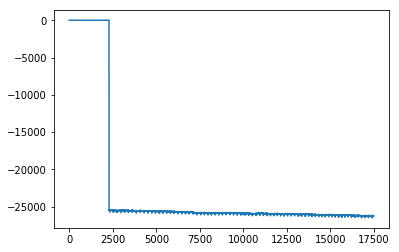

In [109]:
plt.plot(ch30[:17500])
plt.show()

In [85]:
find_files('Part_7_S_Trial15_emotion.bdf')

['']

In [ ]:
path = mne.datasets.mtrf.data_path()
decim = 2
data = loadmat(join(path, 'speech_data.mat'))
raw = data['EEG'].T
speech = data['envelope'].T
sfreq = float(data['Fs'])
sfreq /= decim
speech = mne.filter.resample(speech, down=decim, npad='auto')
raw = mne.filter.resample(raw, down=decim, npad='auto')

# Read in channel positions and create our MNE objects from the raw data
montage = mne.channels.read_montage('biosemi128')
montage.selection = montage.selection[:128]
info = mne.create_info(montage.ch_names[:128], sfreq, 'eeg', montage=montage)
raw = mne.io.RawArray(raw, info)
n_channels = len(raw.ch_names)

# Plot a sample of brain and stimulus activity
fig, ax = plt.subplots()
lns = ax.plot(scale(raw[:, :800][0].T), color='k', alpha=.1)
ln1 = ax.plot(scale(speech[0, :800]), color='r', lw=2)
ax.legend([lns[0], ln1[0]], ['EEG', 'Speech Envelope'], frameon=False)
ax.set(title="Sample activity", xlabel="Time (s)")
mne.viz.tight_layout()